In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

Using TensorFlow backend.


In [3]:
DATAFILE = '/home/amaiya/data/groningen_meaning_bank/ner_dataset.csv'
(trn, val, preproc) = text.entities_from_csv(DATAFILE,
                                             sentence_column='Sentence #',
                                             word_column='Word',
                                             tag_column='Tag', 
                                             maxlen=100)

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['B-gpe', 'B-eve', 'I-geo', 'B-art', 'I-per', 'I-gpe', 'I-org', 'B-nat', 'I-art', 'I-tim', 'B-org', 'B-tim', 'I-eve', 'O', 'B-per', 'I-nat', 'B-geo']
Number of Labels:  17
Longest sentence: 104 words


In [4]:
text.print_sequence_taggers()

bilstm-crf: Bidirectional LSTM-CRF  (https://arxiv.org/abs/1508.01991)


In [5]:
model = text.sequence_tagger('bilstm-crf', preproc)

In [6]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=512)

simulating training for different learning rates... this may take a few moments...
Epoch 1/4
43163/43163 [==============================] - 52s 1ms/step - loss: 2.6347 - crf_accuracy: 0.0284
Epoch 2/4
43163/43163 [==============================] - 49s 1ms/step - loss: 1.3585 - crf_accuracy: 0.7364
Epoch 3/4
43163/43163 [==============================] - 49s 1ms/step - loss: 0.1420 - crf_accuracy: 0.9679
Epoch 4/4
 2560/43163 [>.............................] - ETA: 46s - loss: 352.2198 - crf_accuracy: 0.7845

done.


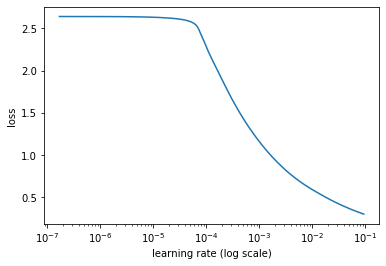

In [7]:
learner.lr_find(max_epochs=4, show_plot=True)

In [8]:
learner.autofit(0.01, 20, checkpoint_folder='/tmp/saved_weights')



begin training using triangular learning rate policy with max lr of 0.01...
Train on 43163 samples, validate on 4796 samples
Epoch 1/20
43163/43163 [==============================] - 51s 1ms/step - loss: 0.7670 - crf_accuracy: 0.7861 - val_loss: 0.2835 - val_crf_accuracy: 0.8626
Epoch 2/20
43163/43163 [==============================] - 51s 1ms/step - loss: 0.2316 - crf_accuracy: 0.9219 - val_loss: 0.1794 - val_crf_accuracy: 0.9544
Epoch 3/20
43163/43163 [==============================] - 51s 1ms/step - loss: 0.1554 - crf_accuracy: 0.9588 - val_loss: 0.1151 - val_crf_accuracy: 0.9683
Epoch 4/20
43163/43163 [==============================] - 51s 1ms/step - loss: 0.1379 - crf_accuracy: 0.9586 - val_loss: 0.1132 - val_crf_accuracy: 0.9604
Epoch 5/20
43163/43163 [==============================] - 51s 1ms/step - loss: 0.0868 - crf_accuracy: 0.9724 - val_loss: 0.0692 - val_crf_accuracy: 0.9804
Epoch 6/20
43163/43163 [==============================] - 51s 1ms/step - loss: 0.0588 - crf_accura

In [10]:
learner.autofit(0.01, 5, checkpoint_folder='/tmp/saved_weights')



begin training using triangular learning rate policy with max lr of 0.01...
Train on 43163 samples, validate on 4796 samples
Epoch 1/5
43163/43163 [==============================] - 51s 1ms/step - loss: 0.0164 - crf_accuracy: 0.9941 - val_loss: 0.0256 - val_crf_accuracy: 0.9917
Epoch 2/5
43163/43163 [==============================] - 52s 1ms/step - loss: 0.0165 - crf_accuracy: 0.9939 - val_loss: 0.0250 - val_crf_accuracy: 0.9917
Epoch 3/5
43163/43163 [==============================] - 51s 1ms/step - loss: 0.0149 - crf_accuracy: 0.9942 - val_loss: 0.0246 - val_crf_accuracy: 0.9918
Epoch 4/5
43163/43163 [==============================] - 51s 1ms/step - loss: 0.0139 - crf_accuracy: 0.9944 - val_loss: 0.0238 - val_crf_accuracy: 0.9919
Epoch 5/5
43163/43163 [==============================] - 51s 1ms/step - loss: 0.0131 - crf_accuracy: 0.9944 - val_loss: 0.0233 - val_crf_accuracy: 0.9918


In [12]:
learner.autofit(0.01, 5, checkpoint_folder='/tmp/saved_weights')



begin training using triangular learning rate policy with max lr of 0.01...
Train on 43163 samples, validate on 4796 samples
Epoch 1/5
43163/43163 [==============================] - 51s 1ms/step - loss: 0.0123 - crf_accuracy: 0.9945 - val_loss: 0.0228 - val_crf_accuracy: 0.9919
Epoch 2/5
43163/43163 [==============================] - 51s 1ms/step - loss: 0.0114 - crf_accuracy: 0.9946 - val_loss: 0.0219 - val_crf_accuracy: 0.9919
Epoch 3/5
43163/43163 [==============================] - 51s 1ms/step - loss: 0.0106 - crf_accuracy: 0.9947 - val_loss: 0.0215 - val_crf_accuracy: 0.9919
Epoch 4/5
43163/43163 [==============================] - 51s 1ms/step - loss: 0.0097 - crf_accuracy: 0.9948 - val_loss: 0.0219 - val_crf_accuracy: 0.9919
Epoch 5/5
43163/43163 [==============================] - 52s 1ms/step - loss: 0.0089 - crf_accuracy: 0.9949 - val_loss: 0.0213 - val_crf_accuracy: 0.9919


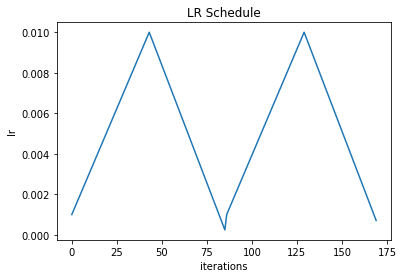

In [8]:
learner.plot('lr')

In [13]:
learner.validate(class_names=preproc.get_classes())

           precision    recall  f1-score   support

      org       0.71      0.65      0.68      2020
      tim       0.87      0.82      0.84      1991
      gpe       0.96      0.95      0.96      1599
      geo       0.83      0.87      0.85      3707
      per       0.74      0.66      0.70      1736
      eve       0.36      0.33      0.34        30
      art       0.25      0.14      0.18        28
      nat       0.19      0.12      0.15        25

micro avg       0.82      0.79      0.81     11136
macro avg       0.82      0.79      0.80     11136



In [10]:
learner.autofit(0.01, 4, checkpoint_folder='/tmp/saved_weights_2')



begin training using triangular learning rate policy with max lr of 0.01...
Train on 43163 samples, validate on 4796 samples
Epoch 1/4
43163/43163 [==============================] - 49s 1ms/step - loss: 0.0201 - crf_accuracy: 0.9939 - val_loss: 0.0301 - val_crf_accuracy: 0.9914
Epoch 2/4
43163/43163 [==============================] - 49s 1ms/step - loss: 0.0187 - crf_accuracy: 0.9941 - val_loss: 0.0296 - val_crf_accuracy: 0.9915
Epoch 3/4
43163/43163 [==============================] - 50s 1ms/step - loss: 0.0176 - crf_accuracy: 0.9943 - val_loss: 0.0289 - val_crf_accuracy: 0.9917
Epoch 4/4
43163/43163 [==============================] - 50s 1ms/step - loss: 0.0165 - crf_accuracy: 0.9945 - val_loss: 0.0284 - val_crf_accuracy: 0.9916


In [12]:
learner.autofit(0.01, 4, checkpoint_folder='/tmp/saved_weights_3')



begin training using triangular learning rate policy with max lr of 0.01...
Train on 43163 samples, validate on 4796 samples
Epoch 1/4
43163/43163 [==============================] - 49s 1ms/step - loss: 0.0153 - crf_accuracy: 0.9948 - val_loss: 0.0283 - val_crf_accuracy: 0.9917
Epoch 2/4
43163/43163 [==============================] - 49s 1ms/step - loss: 0.0145 - crf_accuracy: 0.9949 - val_loss: 0.0277 - val_crf_accuracy: 0.9917
Epoch 3/4
43163/43163 [==============================] - 50s 1ms/step - loss: 0.0177 - crf_accuracy: 0.9944 - val_loss: 0.0299 - val_crf_accuracy: 0.9914
Epoch 4/4
43163/43163 [==============================] - 49s 1ms/step - loss: 0.0140 - crf_accuracy: 0.9949 - val_loss: 0.0271 - val_crf_accuracy: 0.9918


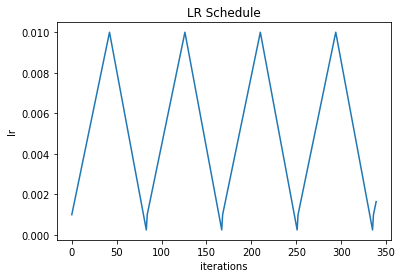

In [14]:
learner.plot('lr')

In [13]:
learner.validate(class_names=preproc.get_classes())

           precision    recall  f1-score   support

      tim       0.86      0.80      0.83      2006
      org       0.72      0.63      0.67      2023
      geo       0.83      0.86      0.85      3791
      per       0.72      0.70      0.71      1621
      gpe       0.96      0.92      0.94      1598
      art       0.18      0.08      0.11        36
      eve       0.50      0.37      0.43        35
      nat       0.27      0.23      0.25        13

micro avg       0.82      0.79      0.80     11123
macro avg       0.81      0.79      0.80     11123



In [10]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [11]:
predictor.predict('During his Presidency, Barack Obama made several visits to Afghanistan.')

[('In', 'O'),
 ('the', 'O'),
 ('United', 'B-geo'),
 ('States', 'I-geo'),
 (',', 'O'),
 ('most', 'O'),
 ('people', 'O'),
 ('think', 'O'),
 ('Barack', 'B-per'),
 ('Obama', 'I-per'),
 ('was', 'O'),
 ('a', 'O'),
 ('much', 'O'),
 ('better', 'O'),
 ('leader', 'O'),
 ('than', 'O'),
 ('Donald', 'B-per'),
 ('Trump', 'I-per'),
 ('.', 'O')]

In [27]:
example = preproc.undo_val(val, val_id=256)

In [28]:
example

[('Polish', 'B-gpe'),
 ('President', 'B-per'),
 ('Lech', 'I-per'),
 ('Kaczynski', 'I-per'),
 ('and', 'O'),
 ('his', 'O'),
 ('brother', 'O'),
 ('Jaroslaw', 'B-geo'),
 (',', 'O'),
 ('the', 'O'),
 ('prime', 'O'),
 ('minister', 'O'),
 (',', 'O'),
 ('have', 'O'),
 ('vowed', 'O'),
 ('to', 'O'),
 ('root', 'O'),
 ('out', 'O'),
 ('those', 'O'),
 ('in', 'O'),
 ('public', 'O'),
 ('life', 'O'),
 ('with', 'O'),
 ('close', 'O'),
 ('ties', 'O'),
 ('to', 'O'),
 ('the', 'O'),
 ('communist', 'O'),
 ('apparatus', 'O'),
 ('.', 'O')]

In [29]:
predictor.predict(" ".join([x[0] for x in example]))

[('Polish', 'B-gpe'),
 ('President', 'B-per'),
 ('Lech', 'I-per'),
 ('Kaczynski', 'I-per'),
 ('and', 'O'),
 ('his', 'O'),
 ('brother', 'O'),
 ('Jaroslaw', 'B-per'),
 (',', 'O'),
 ('the', 'O'),
 ('prime', 'O'),
 ('minister', 'O'),
 (',', 'O'),
 ('have', 'O'),
 ('vowed', 'O'),
 ('to', 'O'),
 ('root', 'O'),
 ('out', 'O'),
 ('those', 'O'),
 ('in', 'O'),
 ('public', 'O'),
 ('life', 'O'),
 ('with', 'O'),
 ('close', 'O'),
 ('ties', 'O'),
 ('to', 'O'),
 ('the', 'O'),
 ('communist', 'O'),
 ('apparatus', 'O'),
 ('.', 'O')]

In [30]:
predictor.save('/tmp/mypred')

In [31]:
reloaded_predictor = ktrain.load_predictor('/tmp/mypred')

In [34]:
reloaded_predictor.predict('Paul Newman is my favorite American actor.')

[('Paul', 'B-per'),
 ('Newman', 'I-per'),
 ('is', 'O'),
 ('my', 'O'),
 ('favorite', 'O'),
 ('American', 'B-gpe'),
 ('actor', 'O'),
 ('.', 'O')]